In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model

In [2]:
dhw_merge = pd.read_csv('dhw_merge.csv')
elec_merge  = pd.read_csv('elec_merge.csv')
n_elec_merge = pd.read_csv('n_elec_merge.csv')

dhw_merge = dhw_merge.drop(['YEAR'], axis=1)
elec_merge = elec_merge.drop(['YEAR'], axis=1)
n_elec_merge = n_elec_merge.drop(['YEAR'], axis=1)

##  For Scaling

In [3]:
dhw_X = dhw_merge.drop(['DHW'], axis=1)
dhw_Y = dhw_merge[['DHW']]

scaler_dhw = MinMaxScaler()
scaler_dhw.fit(dhw_X)
scaled_dhw_X = scaler_dhw.transform(dhw_X)

new_dhw_X = pd.DataFrame(scaled_dhw_X, index=dhw_X.index, columns=dhw_X.columns)
new_dhw = pd.concat([new_dhw_X, dhw_Y], axis=1)

In [4]:
elec_X = elec_merge.drop(['ELEC'], axis=1)
elec_Y = elec_merge[['ELEC']]

scaler_elec = MinMaxScaler()
scaler_elec.fit(elec_X)
scaled_elec_X = scaler_elec.transform(elec_X)

new_elec_X = pd.DataFrame(scaled_elec_X, index=elec_X.index, columns=elec_X.columns)
new_elec = pd.concat([new_elec_X, elec_Y], axis=1)

In [5]:
n_elec_X = n_elec_merge.drop(['n_elec'], axis=1)
n_elec_Y = n_elec_merge[['n_elec']]

scaler_n_elec = MinMaxScaler()
scaler_n_elec.fit(n_elec_X)
scaled_n_elec_X = scaler_n_elec.transform(n_elec_X)

new_n_elec_X = pd.DataFrame(scaled_n_elec_X, index=n_elec_X.index, columns=n_elec_X.columns)
new_n_elec = pd.concat([new_n_elec_X, n_elec_Y], axis=1)

new_n_elec = new_n_elec.iloc[:4724]

In [6]:
input_dhw = new_dhw.iloc[:-1,]
target_dhw = new_dhw[['DHW']].iloc[1:]

trainX_dhw, testX_dhw, trainY_dhw, testY_dhw = train_test_split(input_dhw,target_dhw,test_size=0.3,shuffle=False,random_state=0)

In [7]:
input_elec = new_elec.iloc[:-1,]
target_elec = new_elec[['ELEC']].iloc[1:]

trainX_elec, testX_elec, trainY_elec, testY_elec = train_test_split(input_elec,target_elec,test_size=0.3,shuffle=False,random_state=0)

In [8]:
input = new_n_elec.iloc[:-1,]
target = new_n_elec[['n_elec']].iloc[1:]

trainX_n_elec, testX_n_elec, trainY_n_elec, testY_n_elec = train_test_split(input,target,test_size=0.3,shuffle=False,random_state=0)

In [9]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [10]:
trainx_dhw, trainy_dhw = buildDataSet(trainX_dhw, trainY_dhw, 24)
testx_dhw, testy_dhw = buildDataSet(testX_dhw, testY_dhw, 24)
trainx_elec, trainy_elec = buildDataSet(trainX_elec, trainY_elec, 24)
testx_elec, testy_elec = buildDataSet(testX_elec, testY_elec, 24)
trainx_n_elec, trainy_n_elec = buildDataSet(trainX_n_elec, trainY_n_elec, 24)
testx_n_elec, testy_n_elec = buildDataSet(testX_n_elec, testY_n_elec, 24)

In [11]:
def seq2seq_model(input_shape):
    model_input = tf.keras.layers.Input(shape=input_shape)

    # for feature extracting
    conv1 = tf.keras.layers.Conv1D(64, 1, activation='swish')(model_input)
    pool1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')(conv1)
    conv2 = tf.keras.layers.Conv1D(32, 1, activation='swish')(pool1)
    pool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')(conv2)
    conv3 = tf.keras.layers.Conv1D(128, 1, activation='swish')(pool2)
    pool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')(conv3)

    # 인코더 - 디코더 선언
    encoder_lstm1 = tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh')
    encoder_lstm2 = tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh')
    encoder_lstm3 = tf.keras.layers.LSTM(128, return_state=True, return_sequences=True, activation='tanh')

    decoder_lstm1 = tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh')
    decoder_lstm2 = tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh')
    decoder_lstm3 = tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh')

    # 인코더
    encoder_output_lstm1 = encoder_lstm1(pool3)
    encoder_output_lstm2 = encoder_lstm2(encoder_output_lstm1)
    encoder_output_lstm3, state_h, state_c = encoder_lstm3(encoder_output_lstm2)

    #디코더
    decoder_lstm1_output = decoder_lstm1(encoder_output_lstm3, initial_state=[state_h, state_c])
    decoder_lstm2_output = decoder_lstm2(decoder_lstm1_output)
    decoder_lstm3_output = decoder_lstm3(decoder_lstm2_output)

    flatten = tf.keras.layers.Flatten()(decoder_lstm3_output)
    model_output = tf.keras.layers.Dense(1, activation='swish')(flatten)
    
    model = tf.keras.models.Model(model_input, model_output)
    
    return model

In [12]:
model = seq2seq_model(input_shape=(24, 12))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 12)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 24, 64)       832         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 24, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 24, 32)       2080        ['max_pooling1d[0][0]']          
                                                                                              

In [13]:
# 모델 컴파일
earlystopping = EarlyStopping(monitor='loss', patience=50)
checkpoint = ModelCheckpoint(moniter='loss',filepath='NELEC_source_sizedown.h5')
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adamax(learning_rate=3e-4,clipnorm=1.0), metrics=['mae'])
# 모델 요약 정보 출력
hist = model.fit(trainx_n_elec, trainy_n_elec, epochs=200, batch_size=64, callbacks=[earlystopping,checkpoint])

Epoch 1/200
52/52 [==============================] - 10s 26ms/step - loss: 4.2935 - mae: 4.2935
Epoch 2/200
52/52 [==============================] - 1s 17ms/step - loss: 0.7279 - mae: 0.7279
Epoch 3/200
52/52 [==============================] - 1s 14ms/step - loss: 0.7020 - mae: 0.7020
Epoch 4/200
52/52 [==============================] - 1s 14ms/step - loss: 0.6819 - mae: 0.6819
Epoch 5/200
52/52 [==============================] - 1s 14ms/step - loss: 0.6452 - mae: 0.6452
Epoch 6/200
52/52 [==============================] - 1s 14ms/step - loss: 0.5790 - mae: 0.5790
Epoch 7/200
52/52 [==============================] - 1s 17ms/step - loss: 0.5560 - mae: 0.5560
Epoch 8/200
52/52 [==============================] - 1s 16ms/step - loss: 0.5191 - mae: 0.5191
Epoch 9/200
52/52 [==============================] - 1s 12ms/step - loss: 0.4778 - mae: 0.4778
Epoch 10/200
52/52 [==============================] - 1s 12ms/step - loss: 0.5154 - mae: 0.5154
Epoch 11/200
52/52 [============================

In [14]:
model = load_model('NELEC_source_sizedown.h5')
pred = model.predict(testx_n_elec)
pred = np.reshape(pred,(-1,1))

real = np.array(testy_n_elec)

44/44 [==============================] - 1s 5ms/step


In [15]:
from sklearn.metrics import mean_absolute_error
print('MAE : ', round(mean_absolute_error(real, pred),4)) 

from sklearn.metrics import mean_squared_error
print('MSE : ', round(mean_squared_error(real, pred),4))

from sklearn.metrics import r2_score
print('R2 : ', round(r2_score(real, pred),4))

MAE :  0.1166
MSE :  0.025
R2 :  0.9296


In [16]:
# plt.figure(figsize=(40,10))
# #plt.ylabel('DHW consumption[LighGBM+FCN]',size=20)
# plt.plot(real, color='red', label='True')
# plt.plot(pred, color='blue',label='False')
# plt.legend()
# plt.show()

In [17]:
# trainSize = int(len(elec_ori) * 0.7)
# elec_ori['date'] = pd.to_datetime(elec_ori.iloc[:,:4])
# test_date = elec_ori[['date']].iloc[trainSize:]
# test_date = test_date.iloc[:-3]
# test_date

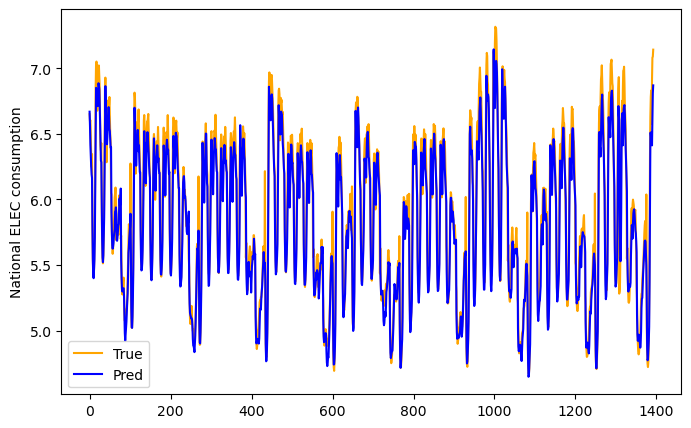

In [18]:
plt.figure(figsize=(8,5))
plt.ylabel('National ELEC consumption')
plt.plot(real, color='orange',label='True')
plt.plot(pred, color='blue',label='Pred')
plt.legend()
plt.show()